# Version 1.1 Notes, important please read!

The first 3 notebooks have been copied as "v1.0 -->> v1.1" and now re-run against a new dataset containing 40 countries. This version addresses limitations discovered in the initial 10-country analysis. Please see:
- 01_migration_graph_basics v1.1.ipynb
- 02_graph_analysis v1.1.ipynb
- 03_graph_metrics_lab2 v1.1.ipynb

Previously we created those notebooks and ran them against only 10 countries. The network density was 97.8%, the average clustering coefficient was 0.9778, average path length 1.02, the degree distribution was nearly uniform too. The result was there were no meaningful patterns, no hubs, no clusters, no emergent properties. It was very approachable to learn, but there was very little I could infer and no emergent properties I could see. I also noticed if there was only one country in a region (such as a continent) it appeared more unique then it probably was - this would be dishonest to the data. It was just obvious 10 countries was not enough.

We made two decisions, the first was the number of countries. Sub-30 it felt like we risked repeating the same issues, over 50 might be overcrowded. With some Googling + AI chat we've settled on 40. 

The second decision was how to select countries, we considered random sampling, stratified sampling, picking them based on data quality, geographic reasons, etc... we settled on:
- Top 30 by total migration volume (incoming + outgoing, 2015 data)
- Strategic 10 additions (ranks 31-50) for geographic balance, migration role diversity, and regional bridges

Reasoning: 
  - Captures dominant global migration flows
  - Natural geographic diversity (top migrants span continents)
  - Computationally feasible for ABM (~1,400 edges, manageable agent counts)
  - Statistically robust (1,560 max possible edges vs. 90)
  - Interpretable for demonstration (can discuss specific countries/hubs)

Before starting we predict this new data set will still have high density, high clustering, short average path length, and while it will be a bit more heterogeneous it will likely be uniform. This is the nature of the data as countries are highly interconnected. The key will be to focus on patterns that emerge from **flow magnitude**

It's quite likely that before we move on to ABM which was to be "notebook 4", we'll instead add a notebook to include some of these metrics (this will be decided when I finish re-running these first three!)
- Weighted degree - Total flow volume (not just connection count)
- Weighted clustering - Do strong mutual connections cluster?
- Weighted betweenness - Bridges for high-volume flows
   Edge-width visualization - Thick = strong flow, thin = weak flow
- Node-size by volume - Identify major hubs visually

Why weighted analysis should work
- Reflects reality (not all connections equal)
- Reveals hidden patterns (regional clusters by flow strength)
- Supports ABM validation (comparing flow magnitudes, not just topology)

Note-to-self, learn weighted NetworkX functions:
- nx.clustering(G, weight='weight') instead of nx.clustering(G)
- G.degree(weight='weight') instead of G.degree()
- Seems to be just adding weight='weight' to the function call! Simple :-)

Backup plan: If nothing emerges and we're not able to infer novel idea's:
1. Threshold filtering - Only add edges with flow > 1,000 migrants
- Reduces density artificially
- Justification: "Filter noise to focus on significant flows"
2. Reduce to 25-30 countries - Quick re-filter and re-run
3. Regional focus pivot - Deep-dive into one migration corridor (20-25 countries, lower density)

**Important: From here down I found+replaced the data source for the new one, and updated my Visualistion Inferences for Report" sections only. You may find references to the 10-country only data set in this and the next two workbooks**


# CITS4403 Project

This notebook kickstarts our project by taking a simple data matrix of our chosen domain of study (migration flows) and applies the knowledge learned in lab 1. 

Our plan is to build on this foundation through subsequent notebooks applying each of the lessons learnt in later labs (where applicable), continually layering on complexity as we go and hopefully observing emergent properties and drawing inferences from the modeling as we go.

**Data Source**: https://figshare.com/collections/Bilateral_international_migration_flow_estimates_for_200_countries/4470464/10

# Migration Flow Graph - The Basics

This notebook builds a simple graph representation of international migration flows.

**Code Goals:**
- Load migration data from CSV
- Create a directed graph with NetworkX
- Visualise the migration network

## Environment Setup

As this is the very start of our project, here's a quick note & reminder on how I start my Python environment in Windows.

1. Open PowerShell in the root of the code folder, run:
   ```bash
   python3 -m venv venv
   ```

2. Activate the virtual environment:
   ```bash
   .\venv\Scripts\Activate
   ```

3. Install dependencies:
   ```bash
   pip install -r requirements.txt
   ```

4. Close & re-open VSCode

5. Run any code block, when prompted for a Python environment(s) select:

   **venv (Python 3.13.7) venv\Scripts\python.exe**

This only needs to be done once.

## Setup

Import the libraries we need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

# Set random seed for reproducibility
# np.random.seed(99) # Commented out, it's not used in this notebook, it's just in a lot of my other study so landed up here, feel free to delete

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Load the Data

Loads the migration data from `../data/bilat_mig_40_countries.csv`

- Reads the CSV file into a DataFrame
- Prints the first few rows to see what it looks like
- Checks the shape (how many rows/columns)

In [2]:
# Loads our pre-processed migration data
df = pd.read_csv('../data/bilat_mig_40_countries.csv')

# Display first few rows to understand the structure
print("First 10 rows of migration data:")
print(df.head(10))
print("\nDataset shape:", df.shape)
print("Columns:", df.columns.tolist())

First 10 rows of migration data:
   year0 orig dest  da_pb_closed
0   2015  SSD  SSD          0.00
1   2015  UGA  SSD      95852.93
2   2015  EGY  SSD       1976.57
3   2015  SDN  SSD     105412.68
4   2015  ZAF  SSD         16.56
5   2015  CIV  SSD          0.63
6   2015  NGA  SSD        416.22
7   2015  CHN  SSD          1.91
8   2015  HKG  SSD          0.00
9   2015  JPN  SSD          0.04

Dataset shape: (1600, 4)
Columns: ['year0', 'orig', 'dest', 'da_pb_closed']


## Explore the Data

Expands on the quick check of the data above by exploring the data a little more, this block:

  - Shows data types and missing values
  - Provides statistics (mean, min, max, etc.)
  - Lists all countries (unique)
  - Shows the range of migration values

Added lots of lines for a little razzle dazzle :-)

In [3]:
# Basic information about the dataset

print("\n" + "="*50)
print("Dataset Info:")
print("="*50)
print(df.info())
print("\n" + "="*50)
print("Statistical Summary:")
print("="*50)
print(df.describe())
print("\n" + "="*50)
print("Unique countries (origins):")
print("="*50)
print(sorted(df['orig'].unique()))

print("\n" + "="*50)
print("Migration flow statistics:")
print("="*50)
print(f"Minimum flow: {df['da_pb_closed'].min()}")
print(f"Maximum flow: {df['da_pb_closed'].max()}")
print(f"Average flow: {df['da_pb_closed'].mean():.2f}")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year0         1600 non-null   int64  
 1   orig          1600 non-null   object 
 2   dest          1600 non-null   object 
 3   da_pb_closed  1600 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 50.1+ KB
None

Statistical Summary:
        year0  da_pb_closed
count  1600.0  1.600000e+03
mean   2015.0  3.397517e+04
std       0.0  1.373465e+05
min    2015.0  0.000000e+00
25%    2015.0  6.455000e+00
50%    2015.0  4.902250e+02
75%    2015.0  1.189240e+04
max    2015.0  2.519678e+06

Unique countries (origins):
['ARE', 'AUS', 'BGD', 'BRA', 'CAN', 'CHN', 'CIV', 'COL', 'DEU', 'EGY', 'ESP', 'FRA', 'GBR', 'HKG', 'IDN', 'IND', 'IRN', 'ITA', 'JOR', 'JPN', 'MEX', 'MMR', 'MYS', 'NGA', 'PAK', 'PHL', 'QAT', 'ROU', 'RUS', 'SAU', 'SDN', 'SSD', 'SYR', 'TUR', 'UGA', 'UKR

## Create the Graph

Basics taken from lab 1 here:
- Using `nx.DiGraph()` to create a directed graph
- Countries are nodes
- Migration flows are the weighted edges (number of migrants)
- Loops through all rows in the dataframe to add edges


In [4]:
# Create an empty directed graph
G = nx.DiGraph()

# Add edges from the dataframe
# Each row represents a migration flow from origin to destination
for index, row in df.iterrows():
    origin = row['orig']
    destination = row['dest']
    flow = row['da_pb_closed']

    # Only add edges where there's actual migration flow, i.e. 0 or flow to/from the same country are ignored
    if flow > 0:
        G.add_edge(origin, destination, weight=flow)

print("Graph created successfully!")
print(f"Added {G.number_of_edges()} migration flows between {G.number_of_nodes()} countries")

Graph created successfully!
Added 1408 migration flows between 40 countries


## Display the Graph Information

Again this is an informative and troubleshooting step to continually check the data is forming as expected:
- How many countries (nodes) are in the graph?
- How many migration flows (edges) were added?
- What are all the country codes?


In [5]:
# Print basic graph statistics
print("="*50)
print("Graph Statistics")
print("="*50)
print(f"Number of countries: {G.number_of_nodes()}")
print(f"Number of migration flows: {G.number_of_edges()}")
print(f"\nCountries in the network:")
print(sorted(list(G.nodes())))

Graph Statistics
Number of countries: 40
Number of migration flows: 1408

Countries in the network:
['ARE', 'AUS', 'BGD', 'BRA', 'CAN', 'CHN', 'CIV', 'COL', 'DEU', 'EGY', 'ESP', 'FRA', 'GBR', 'HKG', 'IDN', 'IND', 'IRN', 'ITA', 'JOR', 'JPN', 'MEX', 'MMR', 'MYS', 'NGA', 'PAK', 'PHL', 'QAT', 'ROU', 'RUS', 'SAU', 'SDN', 'SSD', 'SYR', 'TUR', 'UGA', 'UKR', 'USA', 'VEN', 'VNM', 'ZAF']


## Visualise the Graph

Visualise the migration network:
- Uses a **circular layout** (same as Lab 1) to arrange countries in a circle
- Arrows show the direction of migration flows
- Node labels show country codes

C:\Users\zacba\AppData\Local\Temp\ipykernel_29852\2057748401.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


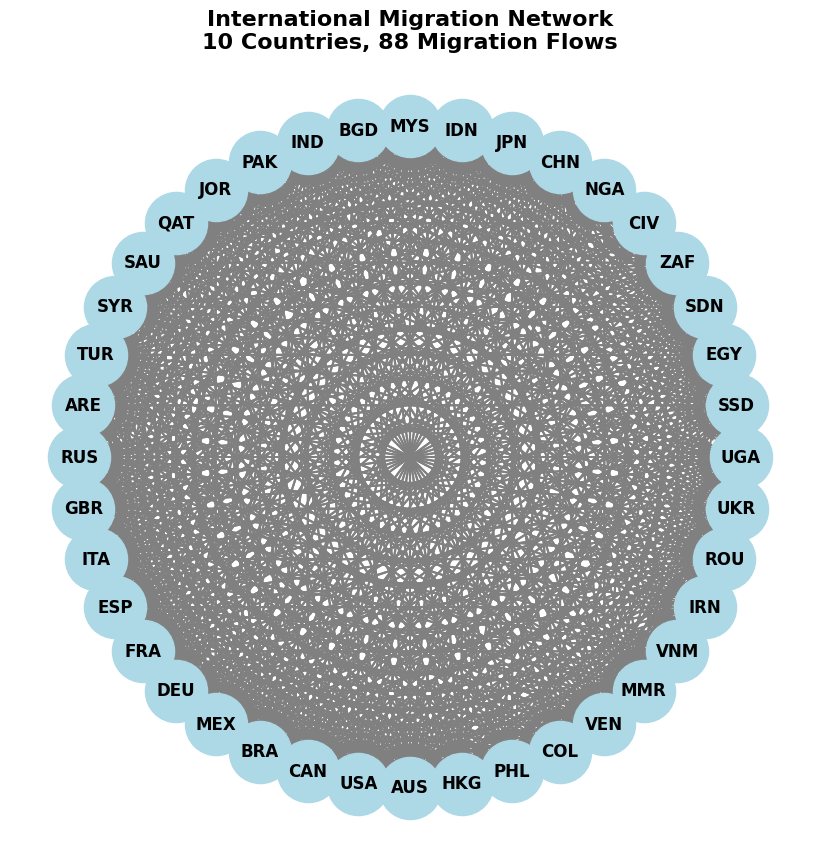

Visualisation complete!


In [6]:
# Create a figure for our graph visualisation (a canvas)
plt.figure(figsize=(8, 8))

# Draw the graph using circular layout, arrows=True for direction origin -> destination.
nx.draw_circular(G, with_labels=True, node_color='lightblue', node_size=2000, font_size=12, font_weight='bold', arrows=True, arrowsize=15, edge_color='gray', width=1.5)

plt.title("International Migration Network\n10 Countries, 88 Migration Flows", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Visualisation complete!")

### Visualisation Inference for Report v1.1

This visualisation worked for 10 countries but not for 40! We use other visualisations in the next workbook so I'm goign to leave it. What the numbers above mean however are good news for our discovery process:
- Minimum flow: 0
- 25th percentile: 6 migrants
- Median: 490 migrants
- 75th percentile: 11,892 migrants
- Maximum: 2,519,678 migrants

Density is high at 90% but there's 6 orders of magnitude variation in flow strength, which is positive news for future weighted analysis, edge-width visualisations and weighted degree analysis. 